<a id='startpage'></a>

# Выбор локации для скважины

**Описание:**

Перед добывающей компанией «ГлавРосГосНефть» стоит вопрос: опеделить, где бурить новую скважину.
В нашем распоряжении пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов. 

**Задача:**
- Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
- Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Описание данных

*	id — уникальный идентификатор скважины;
*	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
*	product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
import pandas as pd
import numpy as np

from IPython.display import display

import scipy.stats as st

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_3 = pd.read_csv('/datasets/geo_data_2.csv')
data_1.tail(5)

,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


Изучим данные каждой таблицы.

In [3]:
def overview(data):
    print(data.sample(3), "\n")
    print(data.info(), "\n")
    print(data.describe(), "\n")
    print("Сумма пропусков:", data.isna().sum(), "\n")
    print("Дубликаты:", data.duplicated().sum(), "\n")
    print("Распределение признаков:")
    data[["f0","f1","f2", "product"]].hist(bins=25)
    plt.show()
    print("Матрица корреляции:")
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix);

          id        f0        f1        f2    product
63433  uX9lM  1.741666 -0.311820  2.064832  77.591459
31116  bVJtr  1.549832 -0.208999 -0.667315  32.868619
74474  Jr20v -0.758084  0.462766 -2.272479  33.935700 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        

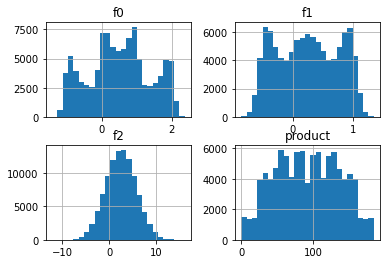

Матрица корреляции:


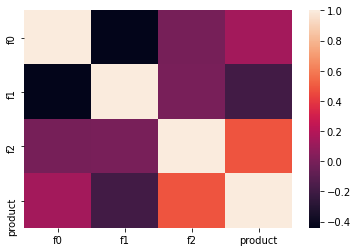

In [4]:
overview(data_1)

Мы наблюдаем слабую корреляцию между целеым признаком `product` и `f2`. Корреляция между признаками  не выявлена.

          id         f0        f1        f2    product
93428  Fe9A6  -4.781584 -5.973907  0.989196  30.132364
29523  oONre  17.791392 -5.103071  1.003086  26.953261
91175  lSWZO   5.576384 -2.204314  1.996439  53.906522 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%    

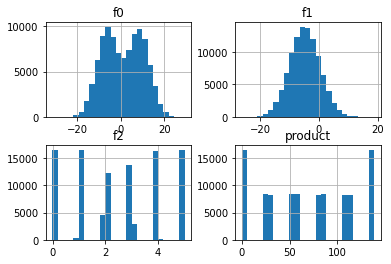

Матрица корреляции:


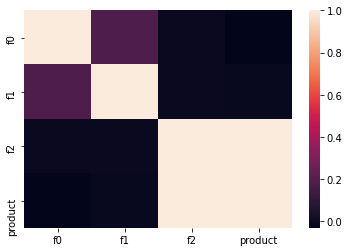

In [5]:
overview(data_2)

Мы наблюдаем весьма высокую силу связи между целевым признаком и `f2`, что показывает на важность признака.

          id        f0        f1        f2     product
63895  icg6q  1.361000  0.536845  4.027827  100.105948
919    9hB1V  1.479176 -0.567824  3.645993   56.003608
59023  rR3uu  2.259767 -0.521430  0.965569  150.971075 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%    

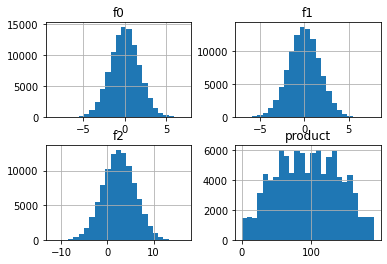

Матрица корреляции:


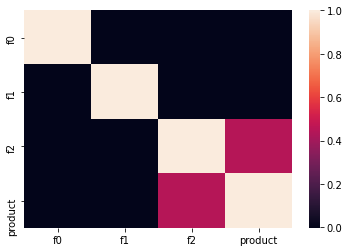

In [6]:
overview(data_3)

В данных нет пропусков, дубликаты не обнаружены. 

Признак `f2` значимый для нашего предсказания для второго региона (data_2).

Распределение данных по гистограммам показывает, что первый (data_1) и третий (data_3) регионы достаточно похожи по распределению целевого признака, а вот во втором (data_2) картина другая: распределение близко к равномерному с выбросами по краям.

Каждый признак распределен симметрично.

Разброс значений в признаках небольшой, масштабирование применять не будем.

## Обучение и проверка модели

Напишем функцию.

In [7]:
def training(data):
    """
    Функция принимает на вход данные.
    Оставляет нужные признаки.
    Делит данные на обучающую и валидационную(тестовую) выборки.
    Обучает линейную модель.
    Расчитывает rmse и средний запас предсказанного сырья.
    Возвращает tuple с предсказаниями, labels, rmse
    """
    
    features = data.drop(["product","id"], axis=1)
    target = data["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target, test_size=0.25, random_state=12345)
    model_lg = LinearRegression()
    model_lg.fit(features_train, target_train)
    predictions = model_lg.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = mean_squared_error(predictions, target_valid)**0.5
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product: {0:.2f}".format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

Сделаем расчеты `RMSE` и `Average product` для наших данных

In [8]:
i = 1
for region in [data_1, data_2, data_3]:
    print(f"Region {i}:\n")
    training(region)
    print("\n\n")
    i+=1

Region 1:

RMSE: 37.58
Average product: 92.59



Region 2:

RMSE: 0.89
Average product: 68.73



Region 3:

RMSE: 40.03
Average product: 94.97





Cохраним predictions, target_valid.reset_index(drop=True), rmse

In [9]:
predictions_1, target_valid_1, rmse_1 = training(data_1)
predictions_2, target_valid_2, rmse_2 = training(data_2)
predictions_3, target_valid_3, rmse_3 = training(data_3)

RMSE: 37.58
Average product: 92.59
RMSE: 0.89
Average product: 68.73
RMSE: 40.03
Average product: 94.97


Внесем результаты в таблицу `summary_1` для наглядности.

In [10]:
summary_1 = pd.DataFrame(data = [['Region 1', 37.58, 92.59],
                                 ['Region 2', 0.89, 68.73],
                               ['Region 3', 40.03, 94.97]], 
                     columns = ['', 'RMSE', 'Average product'])
summary_1

,,RMSE,Average product
0,Region 1,37.58,92.59
1,Region 2,0.89,68.73
2,Region 3,40.03,94.97


RMSE и Average product первого и третьего региона близки, а второго - различны. Как мы видели выше: распределение данных по гистограммам показало отличное от остальных распределение целевого признака во втором регионе.

## Подготовка к расчёту прибыли

Точка безубыточности - объем продаж, при котором прибыль компании равна нулю.

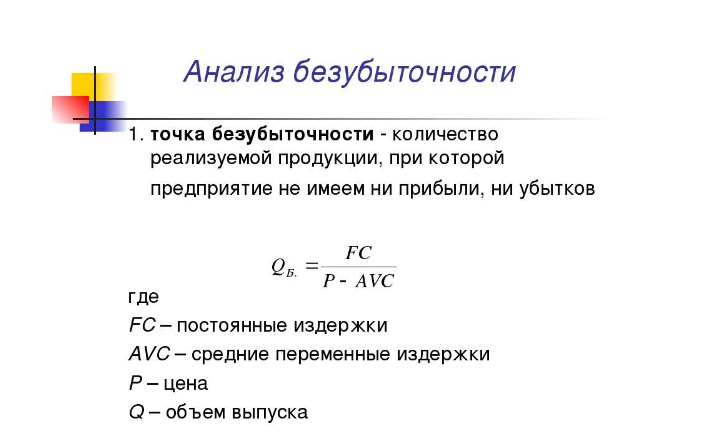

In [11]:
budget = 10**10 # бюджет
income_per_bar = 45*10**4 # доход за баррель нефти
points = 200 # кол-во точек
k = budget/points/income_per_bar
price_ = budget / income_per_bar
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(k))

Точка безубыточности: 111 тыс. баррелей


**Средний запас сырья для каждого исследуемого региона меньше, чем точка безубыточности.**

## Расчёт прибыли и рисков 

### Функция и расчёт прибыли по выбранным скважинам и предсказаниям модели

In [12]:
def profit_calculation(predictions, target_valid, count):
    """
    Функция принимает на вход фактические и прогнозные значения
    объема сырья и количество точек.
    Возвращает фактическую прибыль по лучшим прогнозным точкам.
    """
    top_predictions = predictions.sort_values(ascending=False)
    top_target = target_valid[top_predictions.index][:count]
    revenue = top_target.sum() * income_per_bar
    return (revenue - budget)

In [13]:
print('Фактическая прибыль, руб.:\nрегион 1:', profit_calculation(predictions_1, target_valid_1, points))
print('регион 2:', profit_calculation(predictions_2, target_valid_2, points))
print('регион 3:', profit_calculation(predictions_3, target_valid_3, points))

Фактическая прибыль, руб.:
регион 1: 3320826043.1398506
регион 2: 2415086696.681511
регион 3: 2710349963.5998325


### Расчет рисков и прибыли для каждого региона

In [14]:
def profit_calculation(predictions, target_valid, count):
    """
    Функция принимает на вход фактические и прогнозные значения
    объема сырья и количество точек.
    Возвращает фактическую прибыль по лучшим прогнозным точкам.
    """
    top_predictions = predictions.sort_values(ascending=False)
    top_target = target_valid[top_predictions.index][:count]
    revenue = top_target.sum() * income_per_bar
    return revenue - budget

state = np.random.RandomState(12345)

def result(predictions, target):
    revenue = []
    for i in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit_calculation(predictions_sample, target_sample, points))   # подстановка функции profit_calculation

    
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)

i = 1
for preds, target in zip([predictions_1, predictions_2, predictions_3], 
                         [target_valid_1, target_valid_2, target_valid_3]):
    interval, mean_revenue, risk = result(preds, target)
    print(f"Region {i}:")
    print(f"Средняя прогнозная прибыль, руб.: {mean_revenue}")
    print(f"95% доверительный интервал: {interval}")
    print(f"Риск убытков: {risk}")
    print("\n\n")
    i+=1

Region 1:
Средняя прогнозная прибыль, руб.: 425938526
95% доверительный интервал: (-102090094, 947976353)
Риск убытков: 6.0



Region 2:
Средняя прогнозная прибыль, руб.: 518259493
95% доверительный интервал: (128123231, 953612982)
Риск убытков: 0.3



Region 3:
Средняя прогнозная прибыль, руб.: 420194005
95% доверительный интервал: (-115852609, 989629939)
Риск убытков: 6.2





### Вывод

Самым перспективным для разработки скважин представляется регион 2, в котором риски убытков наименьшие, а средняя прибыль наибольшая.

Вернуться в [начало](#startpage).